In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import cifar10_input

from discretization_utils import one_hot_to_thermometer
from discretization_utils import discretize_uniform
from discretization_attacks import adv_lspga

from cifar_model import Model
import cifar10_input
levels = 16

In [2]:
sess = tf.Session()
cifar = cifar10_input.CIFAR10Data()
model = Model('../models/thermometer_advtrain/',
              sess, tiny=False, mode='eval',
              thermometer=True, levels=levels)

W0219 10:29:23.250988 140016611698496 module_wrapper.py:139] From /home/zhouyi/obfuscated-gradients/thermometer/cifar_model.py:23: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0219 10:29:23.252596 140016611698496 module_wrapper.py:139] From /home/zhouyi/obfuscated-gradients/thermometer/cifar_model.py:23: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0219 10:29:23.253899 140016611698496 module_wrapper.py:139] From /home/zhouyi/obfuscated-gradients/thermometer/cifar_model.py:55: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0219 10:29:23.296678 140016611698496 deprecation.py:323] From /opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/image_ops_impl.py:1518: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
W0219 10:29:23.3

Called


W0219 10:29:24.014867 140016611698496 deprecation.py:323] From /opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py:507: UniformUnitScaling.__init__ (from tensorflow.python.ops.init_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
W0219 10:29:24.026081 140016611698496 module_wrapper.py:139] From /home/zhouyi/obfuscated-gradients/thermometer/cifar_model.py:217: The name tf.nn.xw_plus_b is deprecated. Please use tf.compat.v1.nn.xw_plus_b instead.

W0219 10:29:24.039838 140016611698496 module_wrapper.py:139] From /home/zhouyi/obfuscated-gradients/thermometer/cifar_model.py:186: The name tf.trainable_variables is deprecated. Please use tf.compat.v1.trainable_variables instead.

W0219 10:29:24.058527 140016611698496 module_wrapper.py:139] From /home/zhouyi/obfuscated-gradients/thermometer/cifar_model.py:30: The name tf.trai

restored


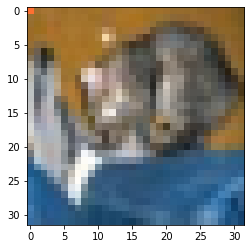

Image Label [3]
255.0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Clean Model Prediction [3]
Logits [[-1.3203267  2.5833201 -5.594299  10.163102  -5.0236144  6.102193
  -4.962522  -3.071897  -1.2005491  2.324844 ]]
246.0
[1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    0.375]
246.0
[1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    0.375]
246.0
[1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    0.375]
246.0
[1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    0.375]
246.0
[1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    0.375]
246.0
[1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    0.375]
246.0
[1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    0.375]
246.0
[1.    1.    1.    1.    1.    1.    1.    1.    1.    1.  

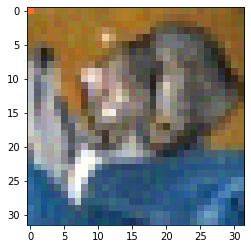

Max distortion 0.031372577
[252.58832 112.64418  41.     ]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Adversarial Model Prediction [5]
Logits [[-1.0054284  0.6727066 -6.330113   1.1263535 -2.2629638 10.420122
  -0.5251962 -1.7024049 -1.5765673  1.1837577]]


In [10]:
class Attack:
    def __init__(self, model, num_steps, step_size, epsilon):
        self.model = model
        self.num_steps = num_steps
        self.step_size = step_size

        self.xs = tf.Variable(np.zeros((1, 32, 32, 3), dtype=np.float32),
                                    name='modifier')
        self.orig_xs = tf.placeholder(tf.float32, [None, 32, 32, 3])

        self.ys = tf.placeholder(tf.int32, [None])

        self.epsilon = epsilon

        delta = tf.clip_by_value(self.xs, 0, 255) - self.orig_xs
        delta = tf.clip_by_value(delta, -self.epsilon, self.epsilon)

        self.do_clip_xs = tf.assign(self.xs, self.orig_xs+delta)
        
        
        # 0.,  16.,  32.,  48.,  64.,  80.,  96., 112., 128., 144., 160., 176., 192., 208., 224.，  256.
        compare = tf.constant((256.0/levels)*np.arange(0,levels).reshape((1,1,1,1,levels)),
                              dtype=tf.float32)
        inner = tf.reshape(self.xs,(-1, 32, 32, 3, 1)) - compare
        inner = tf.maximum(tf.minimum(inner/(256.0/levels), 1.0), 0.0)

        self.therm = tf.reshape(inner, (-1, 32, 32, levels*3))

        self.logits = logits = model(self.therm)

        self.uniform = discretize_uniform(self.xs/255.0, levels=levels, thermometer=True)
        self.real_logits = model(self.uniform)

        label_mask = tf.one_hot(self.ys, 10)
        correct_logit = tf.reduce_sum(label_mask * logits, axis=1)
        wrong_logit = tf.reduce_max((1-label_mask) * logits - 1e4*label_mask, axis=1)

        self.loss = (correct_logit - wrong_logit)

        start_vars = set(x.name for x in tf.global_variables())
        optimizer = tf.train.AdamOptimizer(step_size*1)
        self.grad = tf.sign(tf.gradients(self.loss, self.xs)[0])

        grad,var = optimizer.compute_gradients(self.loss, [self.xs])[0]
        self.train = optimizer.apply_gradients([(tf.sign(grad),var)])

        end_vars = tf.global_variables()
        self.new_vars = [x for x in end_vars if x.name not in start_vars]

    def perturb(self, x, y, sess):
        sess.run(tf.variables_initializer(self.new_vars))
        sess.run(self.xs.initializer)
        sess.run(self.do_clip_xs,
                 {self.orig_xs: x})
        
        for i in range(self.num_steps):

            t = sess.run(self.uniform)
            sess.run(self.train, feed_dict={self.ys: y,
                                            self.therm: t})
            print(sess.run(self.xs)[0][0][0][0])
            print(sess.run(self.therm)[0][0][0].reshape(3, -1)[0])
            sess.run(self.therm)
            sess.run(self.do_clip_xs,
                     {self.orig_xs: x})

        return sess.run(self.xs)
    
    
attack = Attack(model,
                30,
                1,
                8)

xs = tf.placeholder(tf.float32, (1, 32, 32, 3))
encode = discretize_uniform(xs/255.0, levels=levels, thermometer=True)

image = np.array(cifar.eval_data.xs[:1],dtype=np.float32)
label = cifar.eval_data.ys[:1]

image[0][0][0][0] = 255

plt.imshow(image[0]/255.0)
plt.show()
print("Image Label", label)

thermometer_encoded = sess.run(encode, {xs: image})

print(image[0][0][0][0])
print(thermometer_encoded[0][0][0].reshape(3, -1)[0])

print('Clean Model Prediction',
      sess.run(model.predictions, {model.x_input: thermometer_encoded}))
print('Logits',
      sess.run(model.pre_softmax, {model.x_input: thermometer_encoded}))



adversarial = attack.perturb(image, label, sess)
plt.imshow(adversarial[0]/255.0)
plt.show()

print("Max distortion", np.max(np.abs(adversarial/255.0-image/255.0)))

adv_thermometer_encoded = sess.run(encode, {xs: adversarial})

print(adversarial[0][0][0])
print(adv_thermometer_encoded[0][0][0].reshape(3, -1))

print('Adversarial Model Prediction',
      sess.run(model.predictions, {model.x_input: adv_thermometer_encoded}))
print('Logits',
      sess.run(model.pre_softmax, {model.x_input: adv_thermometer_encoded}))

In [21]:
# sess.run(lambda x: print(x), { "fuck"})

TypeError: input must be a dictionary

In [14]:
sess.run(tf.constant((256.0/levels)*np.arange(-1,levels-1).reshape((1,1,1,1,levels)),
                              dtype=tf.float32))

array([[[[[-16.,   0.,  16.,  32.,  48.,  64.,  80.,  96., 112., 128.,
           144., 160., 176., 192., 208., 224.]]]]], dtype=float32)